> **Citing: Grayson, S., & Zhu, W. (Year). "Baby Cry Classifications Using Deep Learning." AIRCC Publishing Corporation, Volume 11 Number 14**


Also the notebook messages are generated by ChatGPT and verified by me to ensure proper idea is delivered to the reader

In [1]:
!pip install librosa==0.9.2

# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

/Users/gloria/Library/Caches/pypoetry/virtualenvs/infant-cry-eRETXQ1W-py3.11/lib/python3.11/site-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>The function create_spectrogram takes an input audio file path and generates a spectrogram image, saving it to the specified image file path. It utilizes the librosa library to load the audio, compute its mel spectrogram, and convert the power spectrogram to a decibel scale for better visualization.</b><br>
    <br>
    &nbsp;<b>The create_pngs_from_wavs function automates the process for multiple audio files within a given directory. It converts all .wav files in the specified input directory into spectrogram images, saving the resulting images to the designated output directory. This function makes use of the create_spectrogram function internally to generate the spectrogram images.</b><br>
</div>

# <span style="font-family:cursive;text-align:center">📊 Data Processing and Training set generation</span>

In [3]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    # ms = librosa.feature.melspectrogram(y, sr=sr) here I created the melspectogram
    ms = librosa.feature.melspectrogram(
        y, sr=sr, n_fft=512, hop_length=128, win_length=512, window='hann' # Created the wideband spectogram
    )
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [4]:
create_pngs_from_wavs('data/donateacry_corpus/belly_pain', 'data/working_2/belly_pain')
create_pngs_from_wavs('data/donateacry_corpus/burping', 'data/working_2/burping')
create_pngs_from_wavs('data/donateacry_corpus/discomfort', 'data/working_2/discomfort')
create_pngs_from_wavs('data/donateacry_corpus/hungry', 'data/working_2/hungry')
create_pngs_from_wavs('data/donateacry_corpus/tired', 'data/working_2/tired')

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>Loading the images from the path</b><br>
</div>

In [5]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    #taking 20 spectrogram each for every label
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>The function takes in source patterns and their corresponding destination paths as input. If the destination directory doesn't exist, it creates the directory and proceeds with moving the files. It utilizes the glob module to identify the files based on the specified patterns and shutil for the file movement.</b><br>
    <br>
    &nbsp;<b>With this we create the training dataset and leave a file for each type for testing.</b><br>
</div>

In [6]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

# Define your directories and source patterns
directories = {
    'data/working_2/belly_pain_train/': 'data/working_2/belly_pain/*.png',
    'data/working_2/burping_train/': 'data/working_2/burping/*.png',
    'data/working_2/discomfort_train/': 'data/working_2/discomfort/*.png',
    'data/working_2/hungry_train/': 'data/working_2/hungry/*.png',
    'data/working_2/tired_train/': 'data/working_2/tired/*.png'
}

# Loop through the directories and move the files
for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)

Directory 'data/working_2/belly_pain_train/' created successfully.
Directory 'data/working_2/burping_train/' created successfully.
Directory 'data/working_2/discomfort_train/' created successfully.
Directory 'data/working_2/hungry_train/' created successfully.
Directory 'data/working_2/tired_train/' created successfully.


In [7]:
images, labels = load_images_from_path('data/working_2/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('data/working_2/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('data/working_2/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('data/working_2/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('data/working_2/tired_train', 4)

x += images
y += labels

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train) # hot encoding
y_test_encoded = to_categorical(y_test)

In [9]:
y_train_encoded[0] # Immagine che fa parte della categoria 3

array([0., 1., 0., 0., 0.])

# <span style="font-family:cursive;text-align:center">⚙️ Model Training</span>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Model Architecture:</font></h3>
    
1. **Input Layer**: Accepts input images of shape (224, 224, 3), which corresponds to images with a height and width of 224 pixels and three color channels (RGB).
2. **Resizing Layer: Resizes the input images to a smaller size of (64, 64). This reduction in image dimensions may help speed up training.
3. **Normalization Layer**: Normalizes pixel values to have zero mean and unit variance, which aids in stabilizing and speeding up the training process.
4. **Convolutional Layers**: Utilizes two convolutional layers:
     - The first convolutional layer has 64 filters, a kernel size of 3x3, and ReLU activation.
     - The second convolutional layer has 128 filters, a kernel size of 3x3, and ReLU activation.
7. **MaxPooling Layer**: Performs max pooling with a pool size of 2x2, reducing the spatial dimensions of the feature maps.
8. **Dropout Layer**: Introduces a dropout rate of 20% to prevent overfitting by randomly deactivating a fraction of neurons during training.
9. **Flatten Layer**: Flattens the 2D feature maps into a 1D vector to prepare for the fully connected layers.
10. **RandomFourierFeatures Layer**: Incorporates random Fourier features with 5 components, which can approximate non-linear mappings efficiently for the data.
11. **Compilation**: Compiles the model using the AdamW optimizer with a learning rate of 0.01, categorical cross-entropy loss function (suitable for multi-class classification), and accuracy as the evaluation metric.

In [10]:
import tensorflow as tf
import numpy as np

class RandomFourierFeatures(tf.keras.layers.Layer):
    def __init__(self, output_dim, scale=10.0):
        super(RandomFourierFeatures, self).__init__()
        self.output_dim = output_dim
        self.scale = scale

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=1.0 / self.scale),
            trainable=False,
        )
        self.b = self.add_weight(
            shape=(self.output_dim,),
            initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi),
            trainable=False,
        )

    def call(self, inputs):
        projection = tf.matmul(inputs, self.W) + self.b
        return tf.math.sqrt(2.0 / self.output_dim) * tf.math.cos(projection)

In [11]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,Normalization,Resizing,InputLayer
#from keras.layers import RandomFourierFeatures da levare
from keras.optimizers import Adam,Adafactor,AdamW,Lion
from keras.optimizers import Adadelta,Adagrad,Adamax,RMSprop,SGD,Nadam,Ftrl

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3))) 
model.add(Resizing(64,64)) # Potrebbe essere tolto o diverso, lui vuole avere immagini più piccole
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2)) # 20% neuroni va scartato
model.add(Flatten()) # appiattiamo risultato ad una dimensione
#model.add(RandomFourierFeatures(5)) # Layer che fa un'approssimazione ----> QUESTO L'ABBIAMO RIMOSSO
model.add(Dense(5, activation='softmax'))  # ABBIAMO AGGIUNTO QUESTA
model.compile(optimizer=AdamW(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       576,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,660 (2.49 MB)

 Trainable params: 651,653 (2.49 MB)

 Non-trainable params: 7 (32.00 B)

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.006,
                              verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.2335 - loss: 5.4253 - val_accuracy: 0.3045 - val_loss: 1.4558 - learning_rate: 0.0100
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.3322 - loss: 1.4947 - val_accuracy: 0.5538 - val_loss: 1.1412 - learning_rate: 0.0100
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.5761 - loss: 1.1093 - val_accuracy: 0.6693 - val_loss: 0.8827 - learning_rate: 0.0100
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.7297 - loss: 0.7885 - val_accuracy: 0.7585 - val_loss: 0.6606 - learning_rate: 0.0100
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8101 - loss: 0.5515 - val_accuracy: 0.8425 - val_loss: 0.5004 - learning_rate: 0.0100
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.8556 - loss: 0.4511 - val_accuracy: 0.8714 - val_loss: 0.3785 - learning_rate: 0.0100
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.9156 - loss: 0.

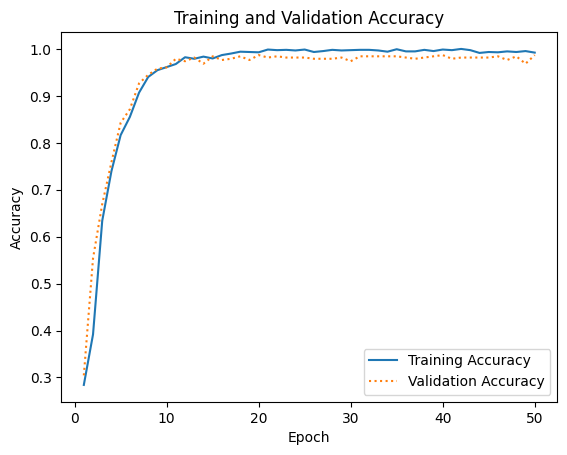

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

# <span style="font-family:cursive;text-align:center">🧪 Testing</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>For predicting on single test files this code will be used. For each image file path obtained, the code performs the following operations:</b><br>
    <br>
    &nbsp;<b>- Loads the image using image.load_img() from the Keras preprocessing module, resizing it to the required dimensions of 224x224 pixels.</b><br>
    &nbsp;<b>- Converts the image to a format compatible with the model for prediction (image.img_to_array() and np.expand_dims()).</b><br>
    &nbsp;<b>- Utilizes the model for prediction on the image.</b><br>
    &nbsp;<b>- Retrieves class labels corresponding to the categories ('belly pain', 'burping', 'discomfort', 'hungry', 'tired').</b><br>
    &nbsp;<b>- Prints the original file path and its predicted category, appending this information to the results list.</b><br>
</div>

In [14]:
import glob
import os

def get_png_files(directory):
    folders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired'] 
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = 'data/working_2/' 
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)

    y = model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    # for i, label in enumerate(class_labels):
    #     print(f'{label}: {y[0][i]}')

    results.append(f"Original:{file_path.split('/')[2]} Predicted: {class_labels[np.argmax(y)]}")
    
print('\n')

for i in results:
    print(i)
    print('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Original:belly_pain Predicted: belly pain


Original:burping Predicted: burping


Original:discomfort Predicted: discomfort


Original:hungry Predicted: hungry


Original:tired Predicted: burping




12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


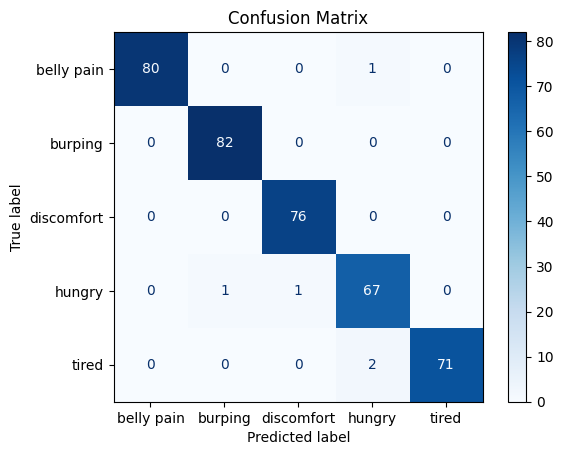

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix with all class labels
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()